# Example: Volatility 

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import yfinance as yf

SPY is the stock code of exchange traded funds that track the performance of the S&P 500 index; it trades like a stock. 

SPX is a value representing the level of the Standard & Poor's 500 Index and cannot be traded directly.

In [15]:
df = pd.read_excel('/Users/sabrina.aufiero/Desktop/COMP0050 Machine Learning with Applications in Finance/Data_Lecture5/sp_20250301.xlsx', sheet_name=0, parse_dates=['date'], index_col='date')
display(df)
# df.rename(columns={'SPX_Close': 'Close'}, inplace=True)

,SPX_Close
date,
2024-04-09,5209.91
2024-04-08,5202.39
2024-04-05,5204.34
2024-04-04,5147.21
2024-04-03,5211.49
...,...
2014-04-16,1862.31
2014-04-15,1842.98
2014-04-14,1830.61


In [16]:
# Calculate 30-Day Rolling Volatility

# Compute daily returns (percentage change)
df['returns'] = df['SPX_Close'].pct_change()

# Compute 30-day rolling standard deviation of returns (this is your "30-day volatility")
df['vol_30d'] = df['returns'].rolling(window=30).std()

# Remove the initial NaNs
df.dropna(subset=['vol_30d'], inplace=True)

display(df)

,SPX_Close,returns,vol_30d
date,,,
2024-02-26,5069.53,-0.001703,0.006219
2024-02-23,5088.80,0.003801,0.006276
2024-02-22,5087.03,-0.000348,0.006273
2024-02-21,4981.80,-0.020686,0.007025
2024-02-20,4975.51,-0.001263,0.006542
...,...,...,...
2014-04-16,1862.31,-0.001362,0.004739
2014-04-15,1842.98,-0.010380,0.005032
2014-04-14,1830.61,-0.006712,0.005058


In [17]:
# K-Means Clustering (k=3) on 30-Day Volatility

# We cluster the single feature: vol_30d
X = df[['vol_30d']].values  # shape: (n_samples, 1)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans.fit(X)

KMeans(n_clusters=3, n_init=10, random_state=42)

In [20]:
# Assign each date to one of the 3 clusters
df['cluster'] = kmeans.labels_

display(df)

,SPX_Close,returns,vol_30d,cluster
date,,,,
2024-02-26,5069.53,-0.001703,0.006219,1
2024-02-23,5088.80,0.003801,0.006276,1
2024-02-22,5087.03,-0.000348,0.006273,1
2024-02-21,4981.80,-0.020686,0.007025,1
2024-02-20,4975.51,-0.001263,0.006542,1
...,...,...,...,...
2014-04-16,1862.31,-0.001362,0.004739,1
2014-04-15,1842.98,-0.010380,0.005032,1
2014-04-14,1830.61,-0.006712,0.005058,1


In [21]:
# Summarize Cluster Results
cluster_counts = df['cluster'].value_counts().sort_index()
print("Number of days in each cluster (k=3):")
print(cluster_counts)

# Average 30-day volatility in each cluster
mean_vol_by_cluster = df.groupby('cluster')['vol_30d'].mean()
print("\nAverage 30-day volatility in each cluster:")
print(mean_vol_by_cluster)

Number of days in each cluster (k=3):
cluster
0      37
1    1633
2     831
Name: count, dtype: int64

Average 30-day volatility in each cluster:
cluster
0    0.047279
1    0.006394
2    0.013678
Name: vol_30d, dtype: float64


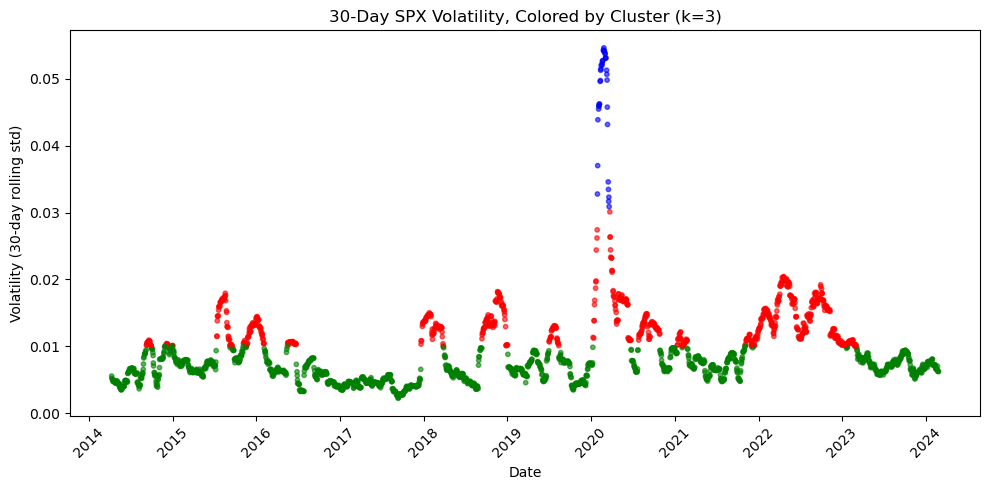

In [22]:
# Plot the Volatility, Colored by Cluster

# Create a color map for the 3 clusters
cluster_colors = {0: 'blue', 1: 'green', 2: 'red'}

# Map each cluster label to a color
colors = df['cluster'].map(cluster_colors)

plt.figure(figsize=(10, 5))
plt.scatter(df.index, df['vol_30d'], c=colors, alpha=0.6, s=10)
plt.title('30-Day SPX Volatility, Colored by Cluster (k=3)')
plt.xlabel('Date')
plt.ylabel('Volatility (30-day rolling std)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [25]:
# Transition Analysis 

# This shows how volatility moves from cluster to cluster day to day.
df['cluster_next'] = df['cluster'].shift(-1)
df.dropna(subset=['cluster_next'], inplace=True)

transition_counts = pd.crosstab(df['cluster'], df['cluster_next'])
print("\nTransition counts from one cluster to the next:")
print(transition_counts)


Transition counts from one cluster to the next:
cluster_next  0.0   1.0  2.0
cluster                     
0              36     0    1
1               0  1605   25
2               1    25  805


In [26]:
transition_probs = transition_counts.div(transition_counts.sum(axis=1), axis=0)
# Multiply by 100 to convert to percentage.
transition_probs_percentage = transition_probs * 100
transition_probs_percentage = transition_probs_percentage.round(2)

print("Transition probabilities (in %):")
print(transition_probs_percentage)

Transition probabilities (in %):
cluster_next    0.0    1.0    2.0
cluster                          
0             97.30   0.00   2.70
1              0.00  98.47   1.53
2              0.12   3.01  96.87


We interpret this as, for example, the probability of jumping from Cluster 1 to Cluster 2 is $1.53\%$ every $30$ days.